Finished filling params dict.
All simulations and tests finished.
Took 0.0025191982587178547 minutes


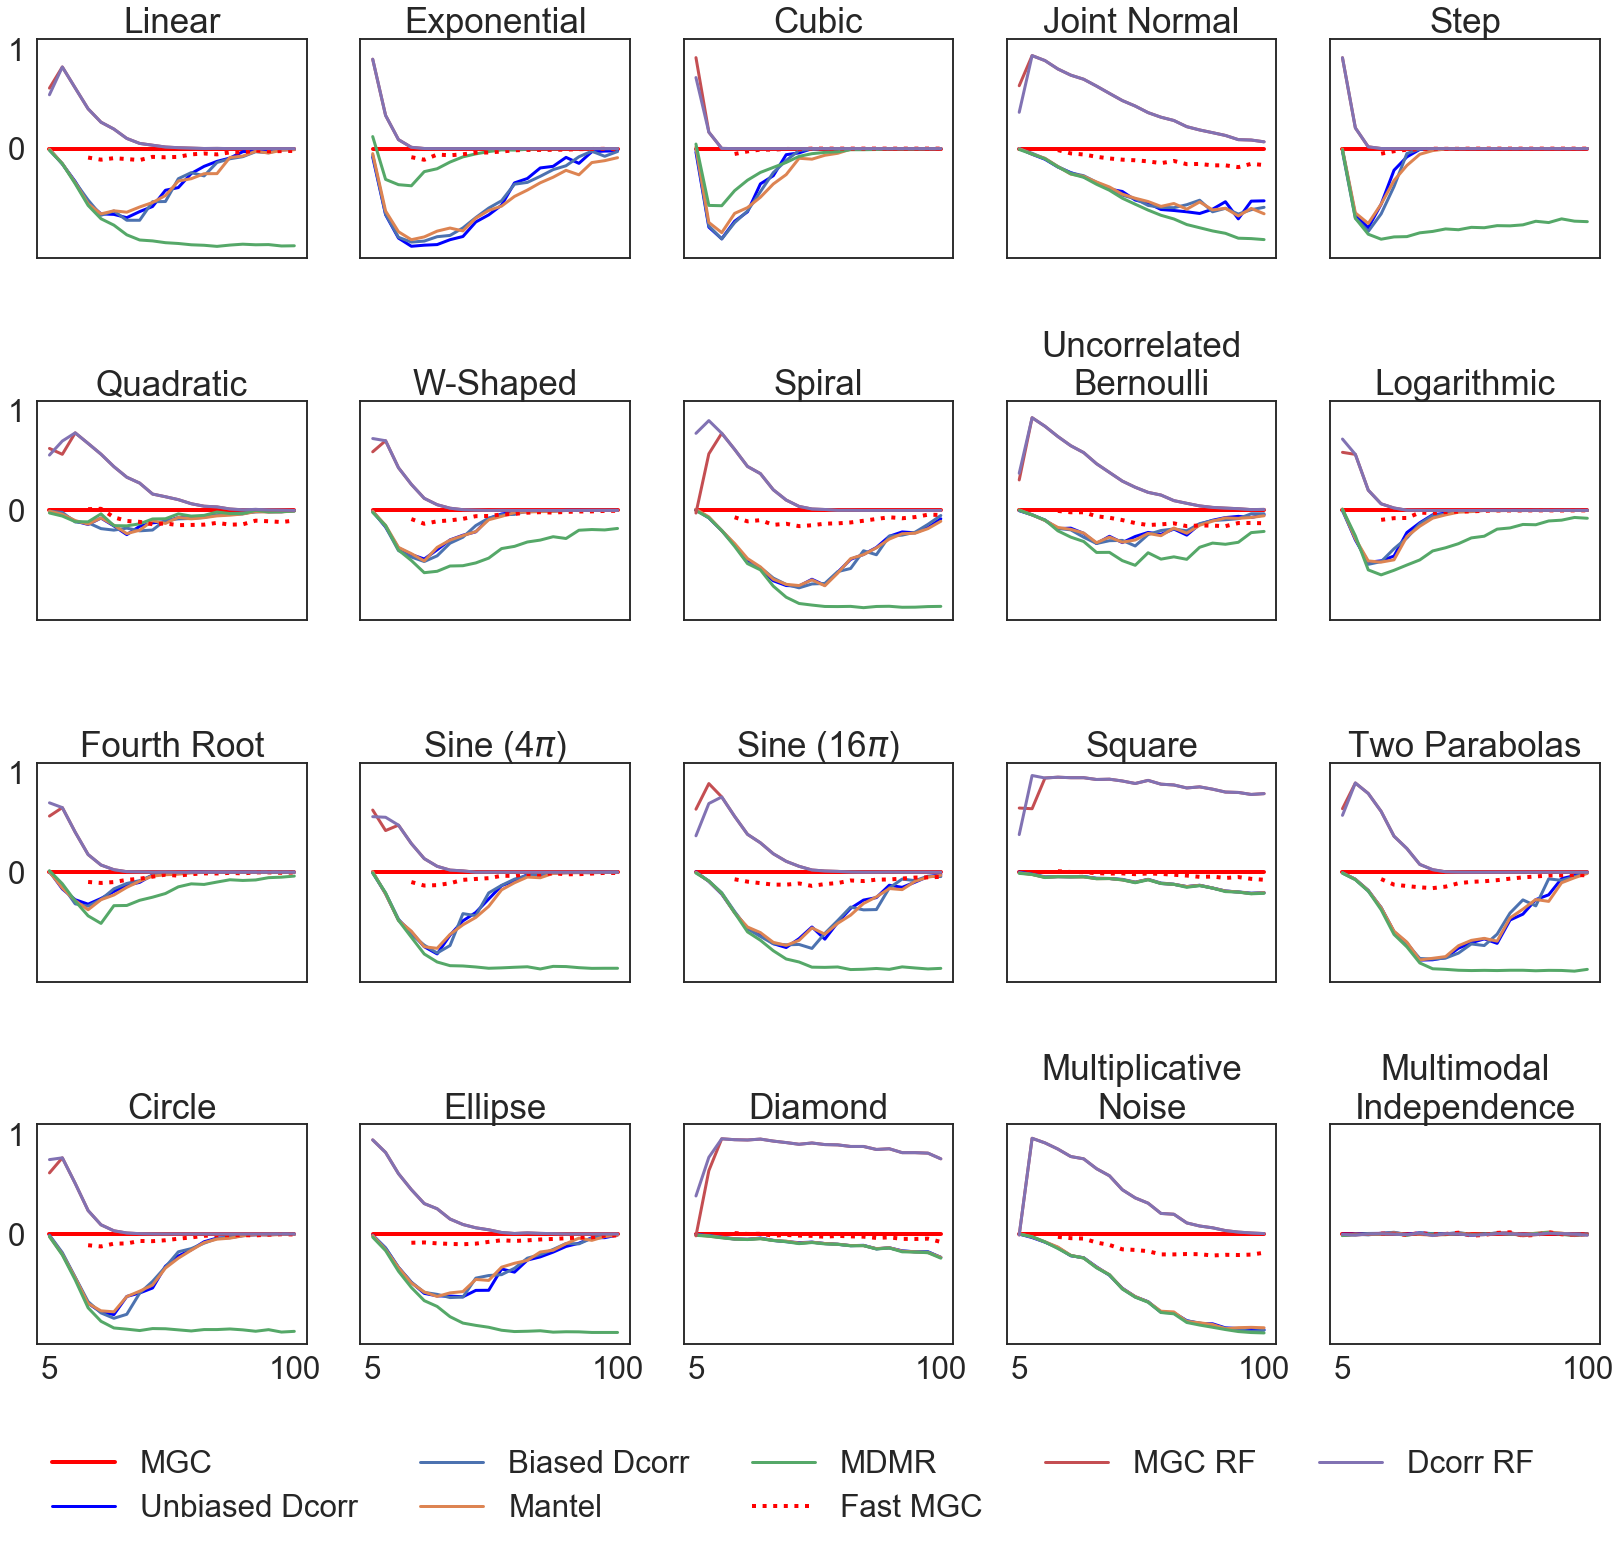

In [3]:
import multiprocessing as mp
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mgcpy.benchmarks.hypothesis_tests.two_sample_test.power import \
    power_given_data
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.mdmr import MDMR
from mgcpy.independence_tests.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr

sns.color_palette('Set1')
sns.set(color_codes=True, style='white', context='talk', font_scale=1.9)


simulations = {'linear': (linear_sim, 1), 'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3), 'joint_normal': (joint_sim, 4), 'step': (step_sim, 5),
               'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 'spiral': (spiral_sim, 8), 'bernoulli': (ubern_sim, 9), 'log': (log_sim, 10),
               'fourth_root': (root_sim, 11), 'sine_4pi': (sin_sim, 12), 'sine_16pi': (sin_sim, 13), 'square': (square_sim, 14), 'two_parabolas': (two_parab_sim, 15),
               'circle': (circle_sim, 16), 'ellipse': (circle_sim, 17), 'diamond': (square_sim, 18), 'multi_noise': (multi_noise_sim, 19), 'multi_indept': (multi_indep_sim, 20)}

plot_titles = ['Linear', 'Exponential', 'Cubic', 'Joint Normal', 'Step', 'Quadratic', 'W-Shaped', 'Spiral',
               'Uncorrelated\nBernoulli', 'Logarithmic', 'Fourth Root', 'Sine (4$\pi$)',
               'Sine (16$\pi$)', 'Square', 'Two Parabolas', 'Circle', 'Ellipse', 'Diamond', 'Multiplicative\nNoise',
               'Multimodal\nIndependence']


def fill_params_dict_list_sample_sizes(base_path, do_fast_mgc=False):
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    hhg = HHG()
    pearson = RVCorr(which_test='pearson')
    mdmr = MDMR()
    independence_tests = [] #[mcorr, dcorr, mantel, mgc, hhg, pearson, mdmr]

    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1], 'base_path': base_path, 'additional_params': {}}
            params_dict_list.append(params_dict)
        if do_fast_mgc:
            fast_mgc = MGC()
            additional_params = {"is_fast": True}
            params_dict = {'independence_test': fast_mgc, 'simulation_type': sim_func[1], 'base_path': base_path, 'additional_params': additional_params}
            params_dict_list.append(params_dict)
    return params_dict_list


def power_vs_sample_size_parallel(params_dict):
    '''
    Generate power of an independence test given a simulation for a range of dimensions

    :param independence_test: an independence_test object
    :param simulation_type: a simulation function from mgcpy.benchmarks.simulations
    :param dim_range: the upper end of the range of dimension
    :return: power for each dimension
    '''
    sample_sizes = [i for i in range(5, 101, 5)]
    estimated_power = np.zeros(len(sample_sizes))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    base_path = params_dict["base_path"]
    additional_params = params_dict['additional_params']
    if additional_params:
        test_name = 'fast_mgc'
    else:
        test_name = test.get_name()

    print(sim, test_name)

    for i in range(len(sample_sizes)):
        # fast mgc doesn't work for less than 20 samples
        if test_name == 'fast_mgc' and sample_sizes[i] < 20:
            estimated_power[i] = np.nan
        else:
            estimated_power[i] = power_given_data(base_path, test, sim, num_samples=sample_sizes[i], additional_params=additional_params)

    np.savetxt(os.path.join(base_path, 'python_power_curves_sample_size/{}_{}_sample_size.csv'.format(sim, test_name)), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test_name))
    return (params_dict, estimated_power)


# for any additional test, add the name of the test (as defined in the `get_name` function in the class)
# in the list `tests` in the following function
def plot_all_curves(base_path):
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28, 24), sharex=True, sharey=True)
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'mdmr', 'fast_mgc', 'mgc_rf', 'dcorr_rf']
            test_names = ['MGC', 'Unbiased Dcorr', 'Biased Dcorr', 'Mantel', 'MDMR', 'Fast MGC', 'MGC RF', 'Dcorr RF']
            dir_name = os.path.join(base_path, 'python_power_curves_sample_size/')

            for test_num, test in enumerate(tests):
                power = np.genfromtxt(dir_name + '{}_{}_sample_size.csv'.format(simulation_type+1, test), delimiter=',')
                mgc_power = np.genfromtxt(dir_name + '{}_mgc_sample_size.csv'.format(simulation_type+1), delimiter=',')

                x_axis = [i for i in range(5, 101, 5)]

                # fast mgc is invalid for sample size less than 20
                if test == 'fast_mgc':
                    power[0:3] = np.nan

                # power = power - mgc_power
                if test == 'mgc':
                    col.plot(x_axis, power - mgc_power, label=test_names[test_num], lw=4, color='red')
                elif test == 'fast_mgc':
                    col.plot(x_axis, power - mgc_power, label=test_names[test_num], lw=4, color='red', linestyle=':')
                elif test == 'unbiased':
                    col.plot(x_axis, power - mgc_power, label=test_names[test_num], lw=3, color='blue')
                else:
                    col.plot(x_axis, power - mgc_power, label=test_names[test_num], lw=3)

                col.set_title(plot_titles[simulation_type], fontsize=35)
                col.set_xticks([x_axis[0], x_axis[-1]])
                # col.set_ylim(-1.1, 1.1)
                # col.set_yticks([-1, 0, 1])
                col.set_ylim(-1.1, 1.1)
                col.set_yticks([0, 1])

            simulation_type += 1

    leg = plt.legend(bbox_to_anchor=(0.5, 0.08), bbox_transform=plt.gcf().transFigure, ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    plt.subplots_adjust(hspace=.65)

    # fig.suptitle('Two Sample Test Power Curve for 20 Simulated 1-Dimensional Settings')
    plt.savefig(os.path.join(base_path, 'two_sample_power_vs_sample_size'), bbox_inches='tight')
    plt.savefig(os.path.join(base_path, 'two_sample_power_vs_sample_size.pdf'), bbox_inches='tight')


if __name__ == '__main__':
    base_path = "/Users/sampan501/workspace/mgcpy/mgcpy/benchmarks/hypothesis_tests/two_sample_test/"
    # base_path = "/Users/pikachu/OneDrive - Johns Hopkins University/Mac Desktop/NDD I/mgcpy/mgcpy/benchmarks/hypothesis_tests/two_sample_test"

    start_time = time.time()
    params_dict = fill_params_dict_list_sample_sizes(base_path, do_fast_mgc=False)
    print('Finished filling params dict.')

    with mp.Pool(mp.cpu_count() - 1) as p:
        outputs = p.map(power_vs_sample_size_parallel, params_dict)

    print('All simulations and tests finished.')
    print('Took {} minutes'.format((time.time() - start_time) / 60))

    plot_all_curves(base_path)


In [47]:
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.hypothesis_tests.transforms import k_sample_transform
from mgcpy.benchmarks.simulations import linear_sim
import numpy as np

np.random.seed(123456789)

x, y = linear_sim(50, 1, noise=0)
angle = np.radians(45)
rot_mat = np.array([[np.cos(angle), -np.sin(angle)],
                    [np.sin(angle), np.cos(angle)]])
data = np.hstack([x, y])
rot_data = (rot_mat @ data.T).T
x_rot, y_rot = np.hsplit(rot_data, 2)
samp1 = np.hstack([x, y])
samp2 = np.hstack([x_rot, y_rot])

u, v = k_sample_transform(samp1, samp2)
dcorr = DCorr(which_test="unbiased")
stat, _ = dcorr.test_statistic(u, v)
pvalue, _ = dcorr.p_value(u, v)
print(stat, pvalue)

0.07865342229765007 0.004


In [19]:
import numpy as np
from mgc.independence import Dcorr

x = np.random.uniform(0, 1, size=50)
y = x + 3
dcorr = Dcorr()
stat, pvalue = dcorr.test(x, y)
stat, pvalue

KeyboardInterrupt: 

In [31]:
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.benchmarks.simulations import linear_sim

x, y = linear_sim(10000, 1)
rvcorr = RVCorr(which_test="cca")
stat, _ = rvcorr.test_statistic(x, y)
pvalue, _ = rvcorr.p_value(x, y)
stat, pvalue

(0.25891549499572386, 0.001)